## Getting Started

Before running the code below, make sure you have installed the following packages:

- pandas
- numpy
- matplotlib
- seaborn
- scikit-learn
- shap
- openpyxl

You can install them using the command below:

```python
!pip install pandas numpy matplotlib seaborn scikit-learn shap openpyxl

In [ ]:
#!pip install pandas numpy matplotlib seaborn scikit-learn shap openpyxl

## 📘 Notebook Title: Pseudostatic Slope Stability Prediction Using Decision Trees and Explainable Machine Learning

In [35]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

import shap
import warnings
warnings.filterwarnings('ignore')


## Step 1: Load the Dataset

In [67]:
# Load the Excel dataset
df = pd.read_excel("Collected Data_PS_GitHub upload.xlsx")

# Preview the dataset
df.head()


,itr,Slope Angle,CbygammaH,phi,kh,kvr,fmp,Xmp,Ymp,Rmp,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,1,15,0.0,10,0.00,-0.5,0.67603,0.23205,5.0,4.93088,NaN,NaN,NaN
1,2,15,0.0,10,0.05,-0.5,0.56581,0.23205,5.0,4.93088,NaN,NaN,NaN
2,3,15,0.0,10,0.10,-0.5,0.48811,0.23205,5.0,4.93088,NaN,NaN,Created by: Waris et al.
3,4,15,0.0,10,0.15,-0.5,0.43041,0.23205,5.0,4.93088,NaN,NaN,NaN
4,5,15,0.0,10,0.20,-0.5,0.38588,0.23205,5.0,4.93088,NaN,NaN,NaN


## Step 2: Dataset Summary

In [69]:
# Summary statistics

print("Shape of the dataset:", df.shape) #df.shape provides us with the row x column dimension

print("\nSummary of dataset:")
print(df.describe())  #Describe numerical data

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Shape of the dataset: (19128, 13)

Summary of dataset:
               itr   Slope Angle     CbygammaH           phi            kh  \
count  19128.00000  19128.000000  19128.000000  19128.000000  19128.000000   
mean    9564.50000     40.956713      0.145564     26.081138      0.149958   
std     5521.92231     15.427276      0.099387     10.771204      0.100009   
min        1.00000     15.000000      0.000000     10.000000      0.000000   
25%     4782.75000     30.000000      0.050000     15.000000      0.050000   
50%     9564.50000     40.000000      0.150000     25.000000      0.150000   
75%    14346.25000     55.000000      0.250000     35.000000      0.250000   
max    19128.00000     65.000000      0.300000     45.000000      0.300000   

                kvr           fmp           Xmp           Ymp           Rmp  \
count  19128.000000  19128.000000  19128.000000  19128.000000  19128.000000   
mean      -0.063624      1.609755     -0.003583      2.624237      2.694049   
std  

## Step 3: Define Features and Target

In [73]:
# Select only the relevant columns by index (Python is 0-indexed)
df = df.iloc[:, 1:7]

# Rename columns
df.columns = ['Slope_Angle', 'CbygammaH', 'phi', 'kh', 'kvr', 'FOS']

# Confirm changes
df.head()
# df.describe()



,Slope_Angle,CbygammaH,phi,kh,kvr,FOS
0,15,0.0,10,0.00,-0.5,0.67603
1,15,0.0,10,0.05,-0.5,0.56581
2,15,0.0,10,0.10,-0.5,0.48811
3,15,0.0,10,0.15,-0.5,0.43041
4,15,0.0,10,0.20,-0.5,0.38588


In [75]:
# Define input features and target
X = df.drop('FOS', axis=1)
y = df['FOS']

## Step 4: Scale the Features

In [77]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for interpretability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)


## Step 5: Train-Test Split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Step 6: Decision Tree with GridSearchCV and K-Fold

In [84]:
# Define the model
dt = DecisionTreeRegressor(random_state=42)

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],   #✅ Meaning of None: None means no limit on the depth of the tree.
                                     #The tree will keep splitting nodes until all leaves are pure or some other stopping criteria 
                                     #(like min_samples_split, min_samples_leaf, etc.) are met.
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup K-Fold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV with 5-fold
grid_search = GridSearchCV(dt, param_grid, cv=cv, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_dt = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


## 🌳 Decision Tree Hyperparameters: Explained

These parameters are commonly used in decision tree-based models such as:

- `DecisionTreeClassifier` / `DecisionTreeRegressor`
- `RandomForestClassifier` / `RandomForestRegressor`
- `GradientBoostingClassifier`, `XGBoost`, `LightGBM`, etc.

They help **control model complexity**, prevent **overfitting**, and improve **generalization**.

---

### 1️⃣ `max_depth: [3, 5, 10, None]`

- Controls how deep the tree can grow.
- Shallower trees → less complex → better generalization.
- `None` means no limit; the tree will grow until it can’t split further.

| Value     | Effect                                |
|-----------|----------------------------------------|
| 3 or 5    | Shallow trees, better generalization   |
| 10        | More flexible, higher capacity         |
| None      | Full growth, risk of overfitting       |

---

### 2️⃣ `min_samples_split: [2, 5, 10]`

- Minimum number of samples required to split an internal node.
- Higher values = fewer splits = simpler, more generalizable tree.

| Value | Effect                                  |
|-------|------------------------------------------|
| 2     | Most splits (default), may overfit       |
| 5     | Balanced                                 |
| 10    | Less splits, stronger regularization     |

---

### 3️⃣ `min_samples_leaf: [1, 2, 4]`

- Minimum number of samples that must be present in a leaf node.
- Prevents the creation of small, noisy leaves.

| Value | Effect                                     |
|-------|---------------------------------------------|
| 1     | Can fit small, noisy patterns (overfit)     |
| 2–4   | Smoothens the tree, improves generalization |

---

## 📦 Example: Grid Search with These Parameters

param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

- Tries all 4 × 3 × 3 = 36 combinations of parameters.

- With cv=5, this results in 180 model fits total.



## Step 7: Model Evaluation

R² Score: 0.9936596369352942
MSE: 0.00516454965345008


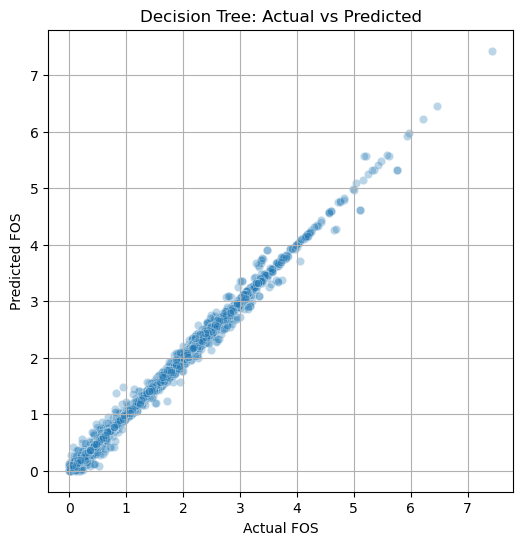

In [88]:
# Predict
y_pred = best_dt.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

# Plot predicted vs actual
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.xlabel("Actual FOS")
plt.ylabel("Predicted FOS")
plt.title("Decision Tree: Actual vs Predicted")
plt.grid(True)
plt.show()


## Step 8: SHAP Interpretation

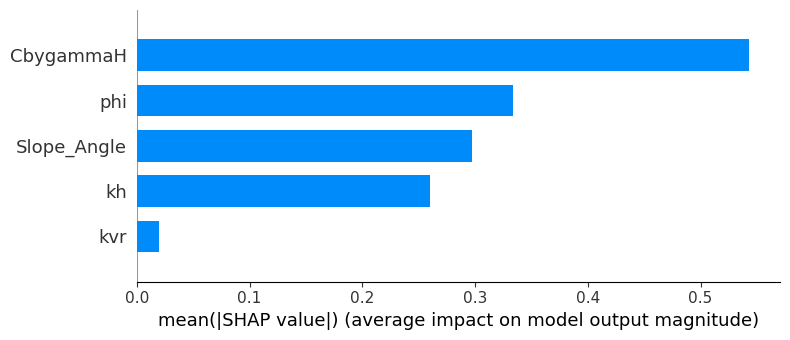

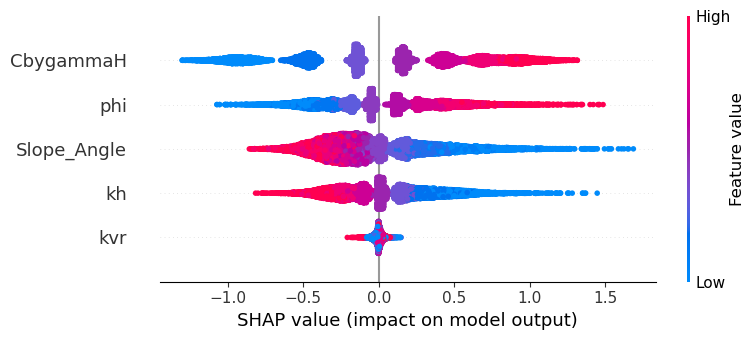

In [91]:
# SHAP explainability
explainer = shap.Explainer(best_dt, X_train)
shap_values = explainer(X_train)

# Summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Detailed beeswarm plot
shap.summary_plot(shap_values, X_train)


## Conclusion Cell

In [94]:
print("""
This notebook demonstrated how to use a Decision Tree Regressor with cross-validation,
hyperparameter tuning, and SHAP analysis to predict the factor of safety for pseudostatic slope stability cases.

This method allows geotechnical engineers to understand not only the prediction, but also the relative importance of input features like friction angle and kh.
""")



This notebook demonstrated how to use a Decision Tree Regressor with cross-validation,
hyperparameter tuning, and SHAP analysis to predict the factor of safety for pseudostatic slope stability cases.

This method allows geotechnical engineers to understand not only the prediction, but also the relative importance of input features like friction angle and kh.



# Hope this notebook has been helpful!
 
Created by: Abdul Waris, PMRF, IIT Hyderabad

For PG students and PhD Scholars at NIT Srinagar (Five Day Workshop on Introduction to FEM and ML in Geotechnical Engineering)